In [1]:
!pip install torchsummary

In [1]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import os
import numpy as np
#import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import functools
import torchvision.models as models
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from skimage import io, transform
from torch.autograd import Variable
from torchvision.utils import save_image
#from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm
from torchvision.utils import save_image

In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
n_channels=1
# VAE latent size
latent_size = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpus = torch.cuda.device_count() if device=='cuda' else 1
batch_size = 160 * n_gpus

lr = 0.0002

beta1=0.5
beta2=0.999

# 14 for 128x128
# 30 for 256x256
if IMG_WIDTH==256:
    patch_gan_output_size=30
elif IMG_WIDTH==128:
    patch_gan_output_size=14

    
DATA_PATH = '...'
SAVE_MODEL_PATH = ''
EPOCH_START=100
PATH_FILENAME_MODEL_GENERATOR='weights/256_generator_epoch_%d.pth' %EPOCH_START
PATH_FILENAME_MODEL_DISCRIMINATOR='weights/256_discriminator_epoch_%d.pth' %EPOCH_START

In [5]:
print(device)

cuda


In [6]:
epochs = 100

In [2]:
loss_g_per_batch = []
loss_d_per_batch = []
loss_g = []
loss_d = []
real_score_per_batch = []
fake_score_per_batch = []
real_score = []
fake_score = []

loss_g_per_batch = np.genfromtxt('logs/losses_g_per_batch_50_epochs.txt')
loss_g_per_batch = np.concatenate([loss_g_per_batch,  np.genfromtxt('logs/losses_g_per_batch_100_epochs.txt')])

loss_d_per_batch = np.genfromtxt('logs/losses_d_per_batch_50_epochs.txt')
loss_d_per_batch = np.concatenate([loss_d_per_batch,  np.genfromtxt('logs/losses_d_per_batch_100_epochs.txt')])

loss_g = np.genfromtxt('logs/losses_g_50_epochs.txt')
loss_g = np.concatenate([loss_g,  np.genfromtxt('logs/losses_g_100_epochs.txt')])

loss_d = np.genfromtxt('logs/losses_d_50_epochs.txt')
loss_d = np.concatenate([loss_d,  np.genfromtxt('logs/losses_d_100_epochs.txt')])

real_score_per_batch = np.genfromtxt('logs/mean_scores_real_per_batch_50_epochs.txt')
real_score_per_batch = np.concatenate([real_score_per_batch,  np.genfromtxt('logs/mean_scores_real_per_batch_100_epochs.txt')])

fake_score_per_batch = np.genfromtxt('logs/mean_scores_fake_per_batch_50_epochs.txt')
fake_score_per_batch = np.concatenate([fake_score_per_batch,  np.genfromtxt('logs/mean_scores_fake_per_batch_100_epochs.txt')])

real_score = np.genfromtxt('logs/mean_scores_real_50_epochs.txt')
real_score = np.concatenate([real_score,  np.genfromtxt('logs/mean_scores_real_100_epochs.txt')])

fake_score = np.genfromtxt('logs/mean_scores_fake_50_epochs.txt')
fake_score = np.concatenate([fake_score,  np.genfromtxt('logs/mean_scores_fake_100_epochs.txt')])


In [3]:
x_batch=np.arange(1,loss_g_per_batch.shape[0]+1)
x = np.arange(1,loss_g.shape[0]+1)

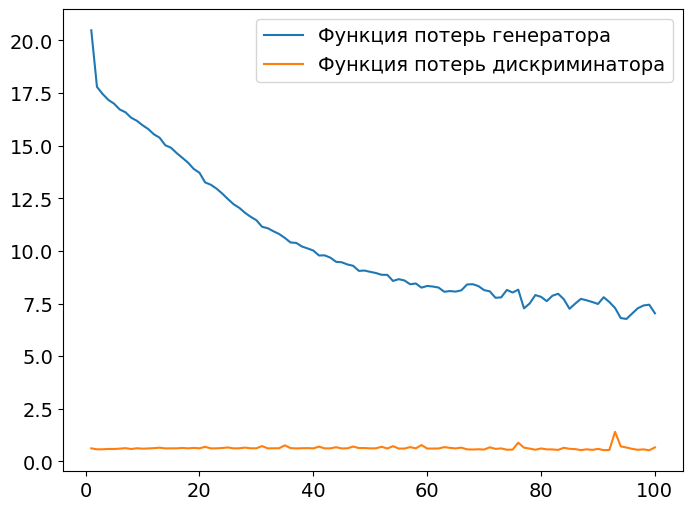

In [4]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 14})

plt.plot(x, loss_g, label='Функция потерь генератора')
plt.plot(x, loss_d, label='Функция потерь дискриминатора')
plt.legend()

plt.show()

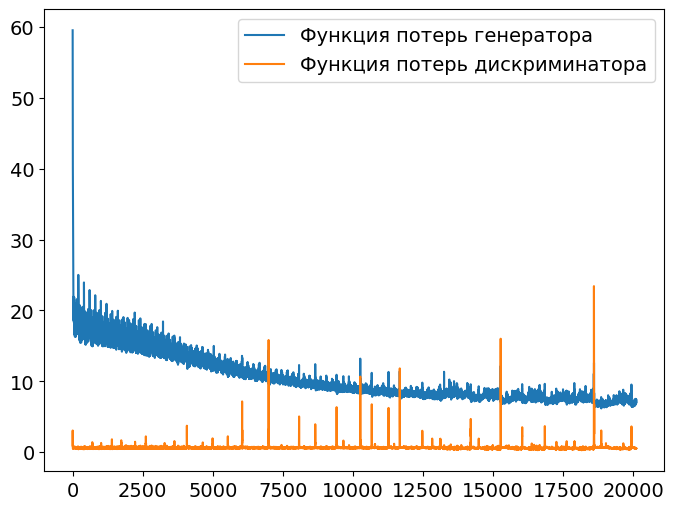

In [5]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 14})

plt.plot(x_batch, loss_g_per_batch, label='Функция потерь генератора')
plt.plot(x_batch, loss_d_per_batch, label='Функция потерь дискриминатора')
plt.legend()

plt.show()


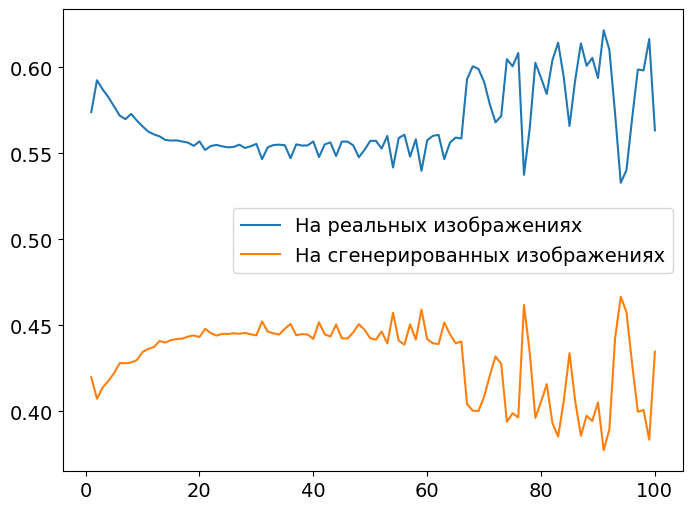

In [6]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 14})

plt.plot(x, real_score, label='На реальных изображениях')
plt.plot(x, fake_score, label='На сгенерированных изображениях')
plt.legend()

plt.show()

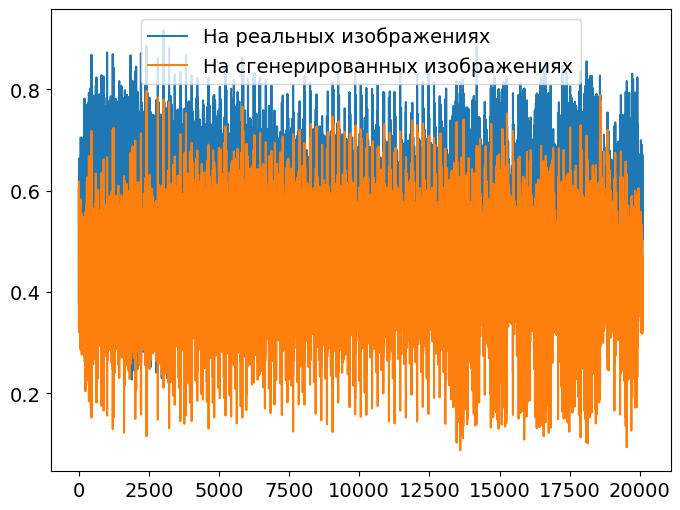

In [7]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 14})

plt.plot(x_batch, real_score_per_batch, label='На реальных изображениях')
plt.plot(x_batch, fake_score_per_batch, label='На сгенерированных изображениях')
plt.legend()

plt.show()

In [6]:
class Split(object):
    def __call__(self, image):
        return transforms.Grayscale(num_output_channels=1)(image[2,:,:].view(1,IMG_WIDTH,IMG_HEIGHT)), transforms.Grayscale(num_output_channels=1)(image[1,:,:].view(1,IMG_WIDTH,IMG_HEIGHT))

In [7]:
dataset = ImageFolder(DATA_PATH, transform=transforms.Compose([
        transforms.Resize(IMG_WIDTH,interpolation=transforms.InterpolationMode.BICUBIC),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.Resize(upsample_transform, interpolation=transforms.InterpolationMode.BICUBIC),
        #transforms.RandomCrop((IMG_WIDTH,IMG_HEIGHT)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
        Split()
        ]))
dataloader = DataLoader(dataset, batch_size)

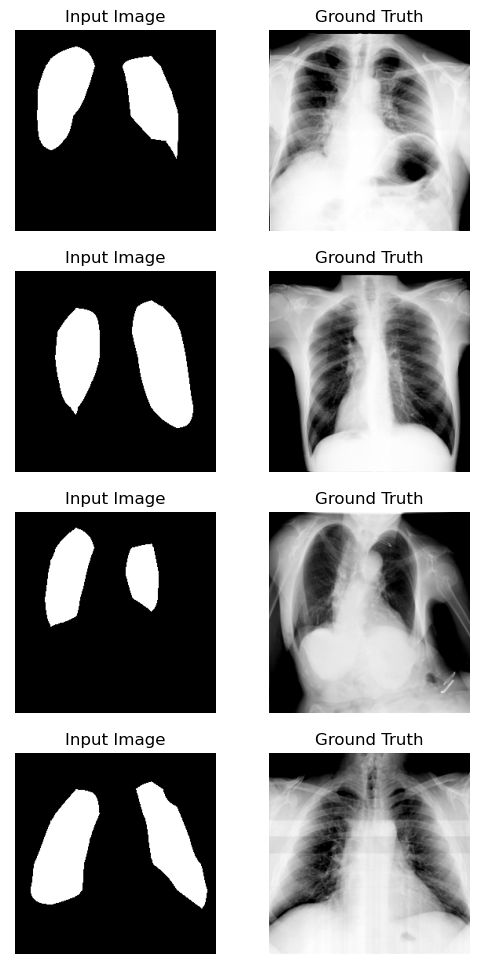

In [8]:
batch,_=next(iter(dataloader))
fig = plt.figure(figsize=(6, 12))
plt.axis("off")
title = ['Input Image', 'Ground Truth']

for j in range(4):
    for i in range(1,3):
        fig.add_subplot(4, 2, j*2+i)
        plt.imshow(batch[i-1][j][0], cmap='gray')
        plt.axis("off")
        plt.title(title[i-1])

In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1,4, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(4,8, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(8,16, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(16,32,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(32,64,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(64,128,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(128,128,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #nn.AvgPool2d(2),
            #nn.Conv2d(256,256,kernel_size=3, stride=1,padding=1),
            #nn.BatchNorm2d(256),
            #nn.ReLU(),
        )
        self.encoder_linear = nn.Linear(128*4*4, latent_size*2)
        self.decoder_linear = nn.Linear(latent_size, 128*4*4)
        self.flatten=nn.Flatten()
        self.unflatten=nn.Unflatten(1,(128,4,4))
        self.relu=nn.ReLU()
        self.decoder = nn.Sequential(
            #nn.Conv2d(256,256,kernel_size=3, stride=1,padding=1),
            #nn.BatchNorm2d(256),
            #nn.ReLU(),
            #nn.Upsample(scale_factor = 2),
            nn.Conv2d(128,128,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(128,64,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(64,32,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(32,16,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(16,8,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(8,4,kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(4,1,kernel_size=3, stride=1,padding=1),
            nn.Tanh()
        )
        
    def encode(self, x):
        x = self.encoder(x)
        x=self.flatten(x)
        x=self.encoder_linear(x).view(x.shape[0],2,-1)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        
        return mu, logsigma#, idx
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            return mu
    
    def decode(self, z):
        z=self.decoder_linear(z)
        z=self.relu(z)
        z=self.unflatten(z)
        z = self.decoder(z)
        reconstruction = torch.sigmoid(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma=self.encode(x)
        reconstruction = self.decode(self.gaussian_sampler(mu, logsigma))

        return reconstruction, mu, logsigma

In [4]:
vae=VAE()
vae.to(device)
vae.load_state_dict(torch.load('weights/vae_epoch_600.pth',map_location=torch.device('cpu')))
vae.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (16): Conv2d(32, 64, kernel

In [ ]:
with torch.no_grad():
    batch[0].apply_(lambda x: (x+1.0)/2.0)
    batch_after_vae,_,_=vae(batch[0].to(device))
    
fig = plt.figure(figsize=(6, 12))
plt.axis("off")
title = ['VAE', 'Ground Truth']

for j in range(4):
    for i in range(1,3):
        fig.add_subplot(4, 2, j*2+i)
        if i==1:
            plt.imshow(batch[i-1][j][0], cmap='gray')
        else:
            plt.imshow(batch_after_vae[j][0].cpu(),cmap='gray')
        plt.axis("off")
        plt.title(title[i-1])

In [6]:
def get_norm_layer():
    """Return a normalization layer
       For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    """
    norm_type = 'batch'
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    return norm_layer

class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, nf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            nf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        
        # add intermediate layers with ngf * 8 filters
        if IMG_WIDTH==256:
            unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
           
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        
        # gradually reduce the number of filters from nf * 8 to nf
        unet_block = UnetSkipConnectionBlock(nf * 4, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(nf * 2, nf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(nf, nf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, nf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)
    
class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

In [7]:
norm_layer = get_norm_layer()

generator = UnetGenerator(n_channels, n_channels, 64, norm_layer=norm_layer, use_dropout=False)
generator = generator.to(device)
generator.load_state_dict(torch.load('weights/256_generator_epoch_100.pth', map_location=torch.device('cpu')))
generator.eval()

UnetGenerator(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(256, 512,

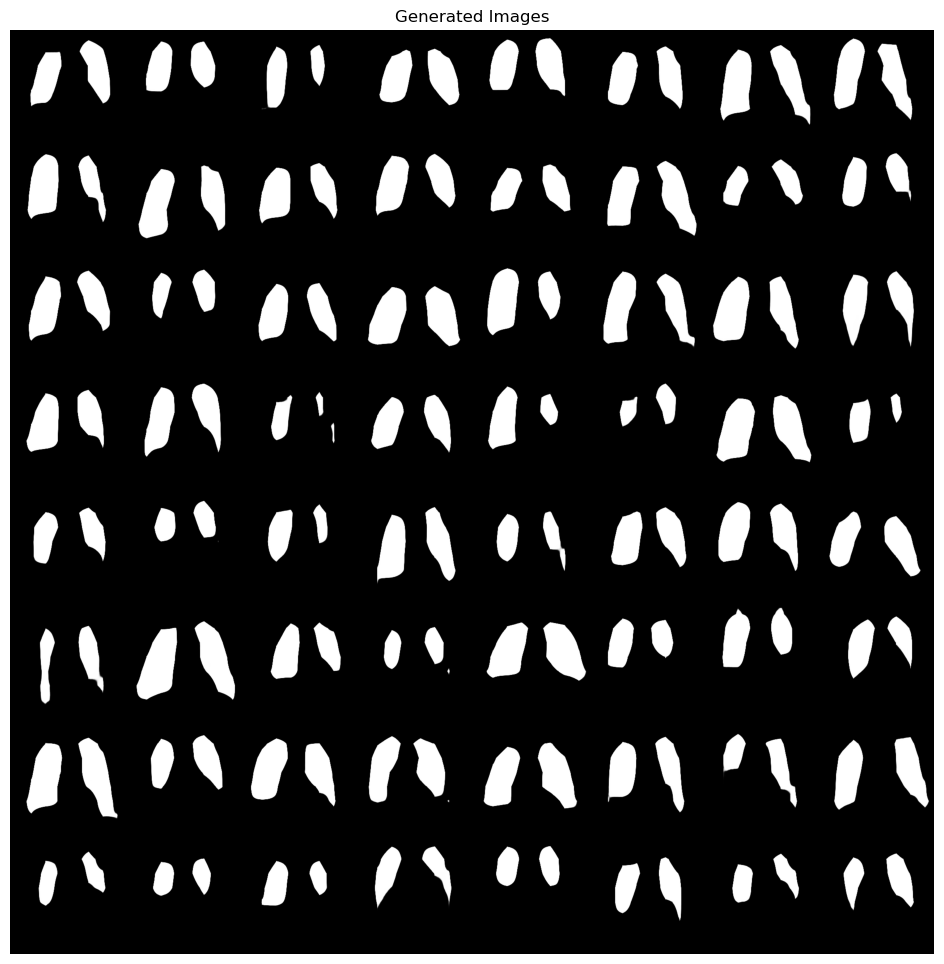

In [9]:
with torch.no_grad():
    z = np.array([np.random.normal(0, 1, latent_size) for i in range(64)])
    output = vae.decode(torch.FloatTensor(z).to(device))

plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(make_grid(output.to(device), padding=2, normalize=True).cpu() ,(1,2,0)))

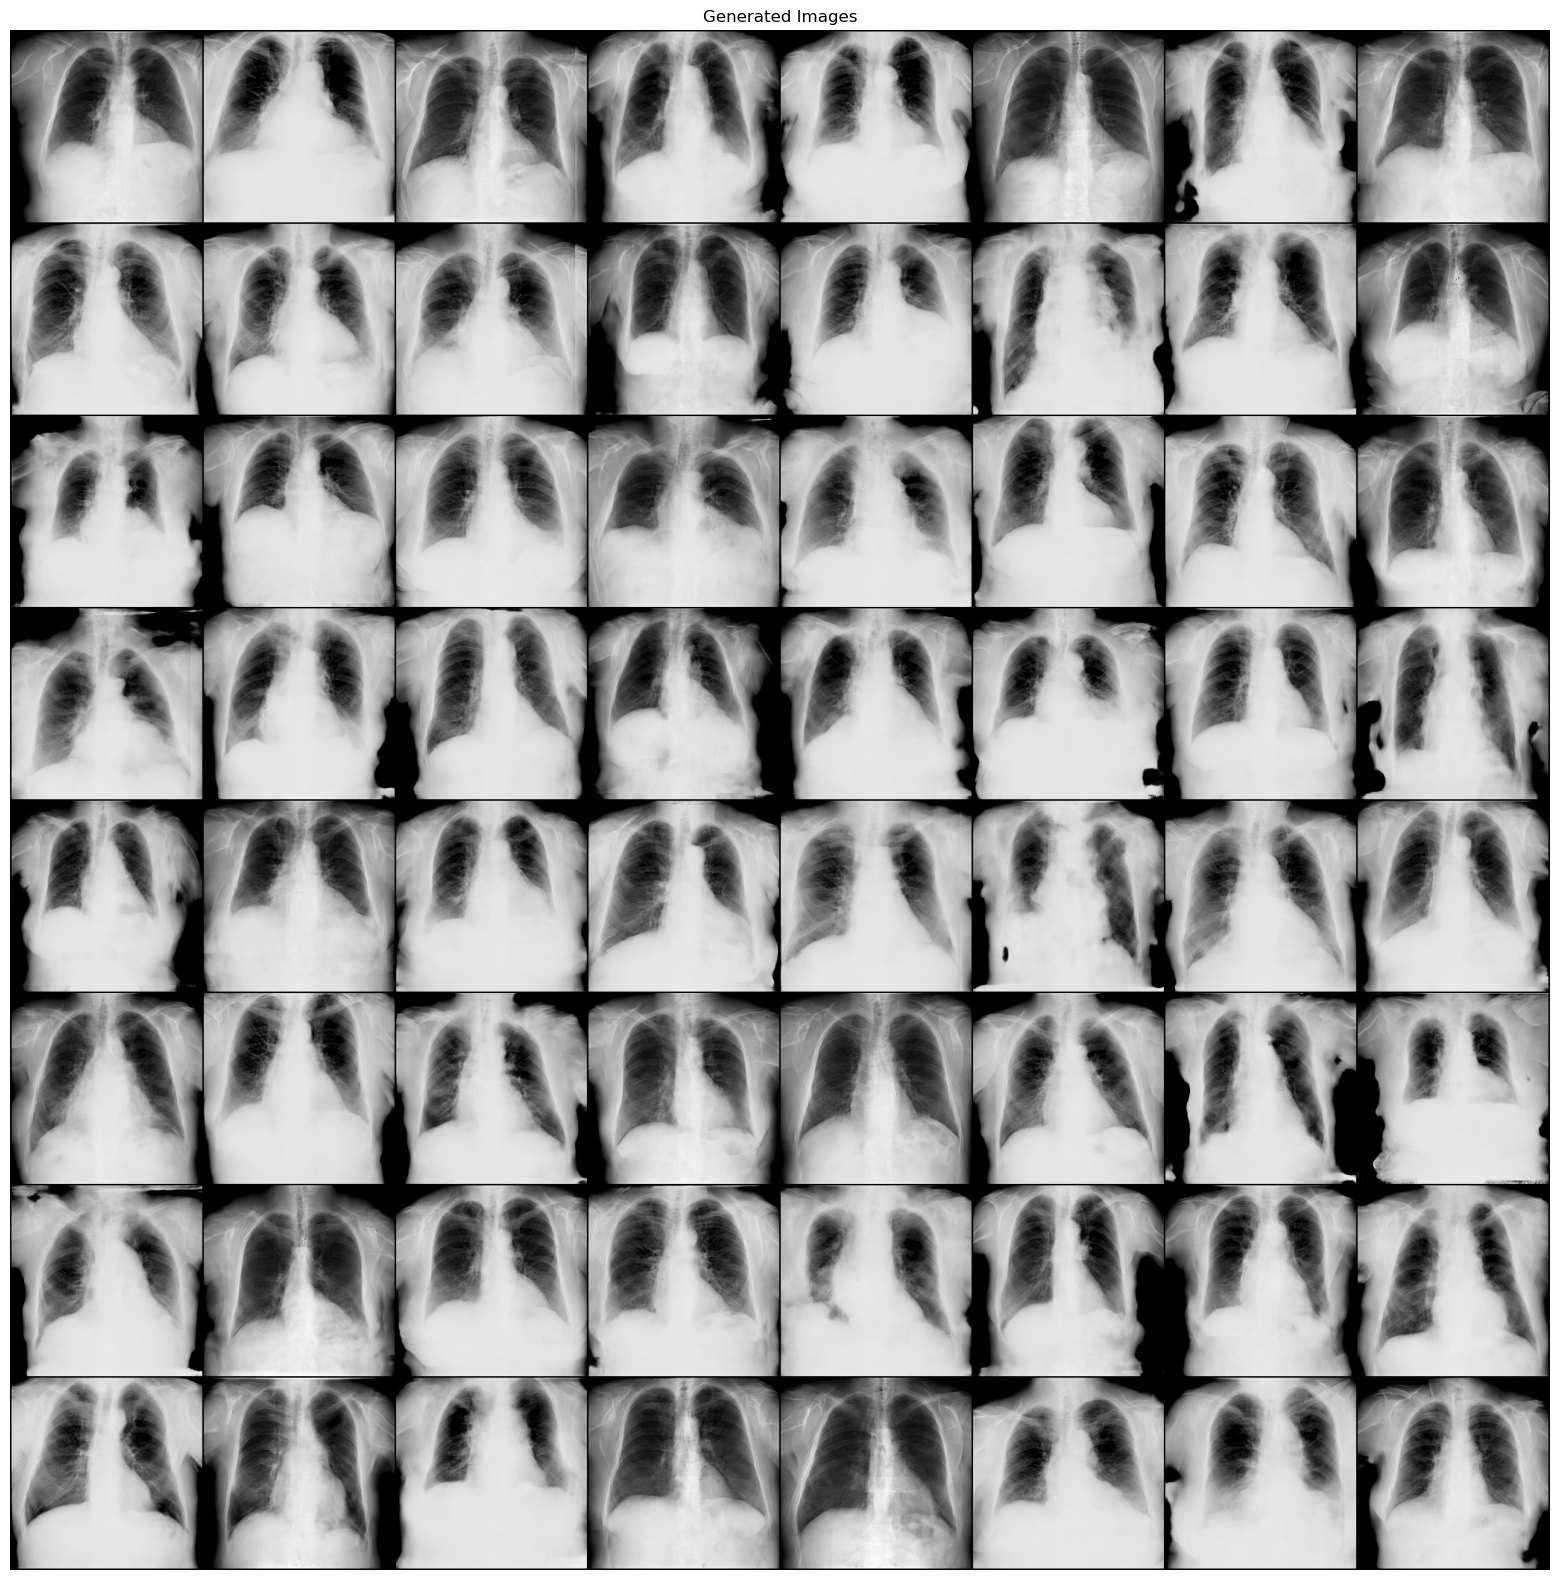

In [8]:
with torch.no_grad():
    z = np.array([np.random.normal(0, 1, latent_size) for i in range(64)])
    output = generator((vae.decode(torch.FloatTensor(z).to(device)) - 0.5)*2)

plt.figure(figsize=(20, 20))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(make_grid(output.to(device), padding=2, normalize=True).cpu() ,(1,2,0)))

In [16]:
#!pip install clean-fid

In [17]:
n_images=len(dataset)
from cleanfid import fid

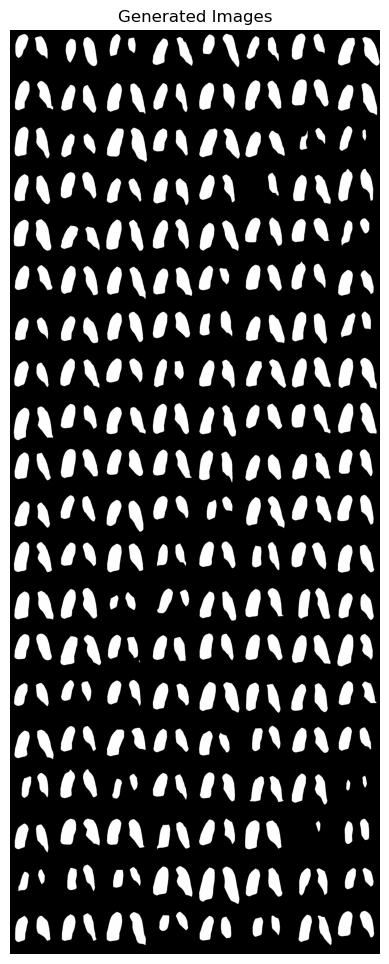

In [25]:
batch, _ = next(iter(dataloader))
masks = (batch[0].to(device)+1)/2.
rec, _, _ = vae(masks)
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(make_grid(rec.to(device), padding=2, normalize=True).cpu() ,(1,2,0)))

In [32]:
def calculate_fid(n_images = 1000, mode='z', rearrange = False, batch_size=64):
    if not os.path.isdir('generated'):
        os.mkdir('generated')
    else:
        if len([name for name in os.listdir('generated')]) != n_images or rearrange:
            folderPath = 'generated'
            for file in os.listdir(folderPath):
                fullFilePath = folderPath + "/" + file
                os.remove(fullFilePath)
    generator.eval()
    vae.eval()
    if len([name for name in os.listdir('generated')]) != n_images or rearrange:    
        with torch.no_grad():
            cnt = n_images//batch_size
            if mode != 'z':
                dataloader = DataLoader(dataset, batch_size)
                i=0
                for batch, _ in tqdm(dataloader):
                    masks = (batch[0].to(device)+1)/2.
                    rec, _, _ = vae(masks)
                    output = generator((rec-0.5)*2)
                    for j in range(len(output)):
                        save_image((output[j]+1)/2., 'generated/%d.png' % (i * batch_size + j))
                    i+=1
            else:
                for i in tqdm(range(cnt)):
                    z = np.array([np.random.normal(0, 1, latent_size) for i in range(batch_size)])
                    output = generator((vae.decode(torch.FloatTensor(z).to(device)) - 0.5)*2)
                    for j in range(batch_size):
                        save_image((output[j]+1)/2., 'generated/%d.png' % (i * batch_size + j))
                if n_images - cnt * batch_size != 0:
                    z = np.array([np.random.normal(0, 1, latent_size) for i in range(n_images - cnt * batch_size)])
                    output = generator((vae.decode(torch.FloatTensor(z).to(device)) - 0.5)*2)
                    for j in range(n_images - cnt * batch_size):
                        save_image((output[j]+1)/2., 'generated/%d.png' % (cnt * batch_size + j))
    #if on cpu num_workers should be >0
    score = fid.compute_fid('pix2pix_xrays_1channel_only', 'generated', mode = 'clean', num_workers = 4, device = device)
    return score

In [ ]:
i=0
for (inp, tar), _ in dataloader:
    for j in range(len(tar)):
        save_image((tar[j]+1)/2., '/kaggle/working/true/%d.png' % (i))
        i+=1

In [34]:
fid_100 = calculate_fid(n_images = n_images, mode = 'masks', rearrange = True, batch_size = 64)
print('FID 100 epochs score: ', fid_100)

100%|█████████████████████████████████████████| 505/505 [10:20<00:00,  1.23s/it]


compute FID between two folders
Found 32263 images in the folder pix2pix_xrays_1channel_only


FID pix2pix_xrays_1channel_only : 100%|█████| 1009/1009 [02:19<00:00,  7.23it/s]


Found 32263 images in the folder generated


FID generated : 100%|███████████████████████| 1009/1009 [02:11<00:00,  7.68it/s]


FID 100 epochs score:  36.81082947121652


In [35]:
fid_100 = calculate_fid(n_images = n_images, mode = 'z', rearrange = True, batch_size = 64)
print('FID 100 epochs score: ', fid_100)

100%|█████████████████████████████████████████| 504/504 [09:12<00:00,  1.10s/it]


compute FID between two folders
Found 32263 images in the folder pix2pix_xrays_1channel_only


FID pix2pix_xrays_1channel_only : 100%|█████| 1009/1009 [02:09<00:00,  7.79it/s]


Found 32263 images in the folder generated


FID generated : 100%|███████████████████████| 1009/1009 [02:09<00:00,  7.79it/s]


FID 100 epochs score:  47.96029792867262
